### ЦЕЛЬ:

Исследовать поведение пользователей в обновлённом приложении.

### ЗАДАЧИ:

1) Определить, насколько обучение сокращает время прохождения этапов игры.
2) Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3) Определить, насколько прозрачен процесс взаимодействия с игрой.

### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ):

1) Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2) Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3) Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Импортируем библиотеку и данные

In [285]:
import pandas as pd

events_df = pd.read_csv('events.csv')
purchase_df = pd.read_csv('purchase.csv')

Отфильтруем полученнные данные в соответствии с заданием и произведем преобразование типа и даты 

In [286]:
cond = (events_df.start_time>='2018-01-01') & (events_df.start_time<'2019-01-01') & (events_df.event_type=='registration')
registered = events_df[cond]['user_id'].to_list()
events_df = events_df[events_df.user_id.isin(registered)]
events_df.start_time = pd.to_datetime(events_df.start_time, format='%Y-%m-%dT%H:%M:%S')

purchase_df['event_type'] = 'purchase'
purchase_df = purchase_df[purchase_df.user_id.isin(registered)]
purchase_df.event_datetime = pd.to_datetime(purchase_df.event_datetime, format='%Y-%m-%dT%H:%M:%S')

Переименуем колонки и произведем объединение

In [287]:
events_df = events_df.rename(columns={'id':'event_id'})
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})

total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Распределим пользователей по группам, в зависимости от прохождения обучения (пользователи, которые завершили обучение, и пользователей, не начинавших обучение). Добавим признак в объединенный датафрейм.

In [288]:
users_with_finished_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_finish"]["user_id"].unique()
set_users_with_finished_tutorial = set(users_with_finished_tutorial)

users_with_started_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)

all_users = total_events_df["user_id"].unique()
set_all_users = set(all_users)

set_users_not_started_tutorial = set_all_users.difference(set_users_with_started_tutorial)
set_users_not_finished_but_started_tutorial = (set_users_with_started_tutorial.difference(set(users_with_finished_tutorial)))

total_events_df['group']=total_events_df.apply(
    lambda x: 'Завершили обучение' if x['user_id'] in set_users_with_finished_tutorial else (
        'Не начинали обучение' if x['user_id'] in set_users_not_started_tutorial else 
        'Не закончили обучение'), 
    axis=1)

Проверим единичность событий кажтого этапа, чтобы выяснить в каких случаях необходимо удалить дубликаты.

In [289]:
event_types = [
    'registration',
    'tutorial_start',
    'tutorial_finish',
    'level_choice',
    'pack_choice',   
]

for event in event_types:
    df= total_events_df[(total_events_df['event_type'] == event) & (total_events_df['user_id'].isin(users_with_finished_tutorial))]
    print(f"Проверка единичности события {event}: ", (df['user_id'].value_counts().mean()) == 1)

Проверка единичности события registration:  True
Проверка единичности события tutorial_start:  False
Проверка единичности события tutorial_finish:  False
Проверка единичности события level_choice:  True
Проверка единичности события pack_choice:  True


Выделим пользователей, закончивших обучение. И сформируем датафреймы по каждому из этапов. Удалим дубликаты, там где это необходимо.

In [290]:
# пользователи, закончившие обучение
users_with_finished_tutorial = total_events_df[total_events_df['group'] == 'Завершили обучение']['user_id'].unique()

# этап регистрации
users_with_finished_tutorial_df_registration = total_events_df[(total_events_df['event_type'] == 'registration') & (total_events_df['user_id'].isin(users_with_finished_tutorial))]
users_with_finished_tutorial_df_registration = users_with_finished_tutorial_df_registration[['user_id','start_time']].rename(columns={'start_time':'registration_time'})
# этап старта обучения
users_with_finished_tutorial_df_tutorial_start = total_events_df[(total_events_df['event_type'] == 'tutorial_start') & (total_events_df['user_id'].isin(users_with_finished_tutorial))]
users_with_finished_tutorial_df_tutorial_start = users_with_finished_tutorial_df_tutorial_start.sort_values("start_time").drop_duplicates("user_id")
print("Проверка единичности события tutorial_start: ", (users_with_finished_tutorial_df_tutorial_start['user_id'].value_counts().mean()) == 1)
users_with_finished_tutorial_df_tutorial_start = users_with_finished_tutorial_df_tutorial_start[['user_id','start_time']].rename(columns={'start_time':'tutorial_start_time'})
# этап финиша обучения
users_with_finished_tutorial_df_tutorial_finish = total_events_df[(total_events_df['event_type'] == 'tutorial_finish') & (total_events_df['user_id'].isin(users_with_finished_tutorial))]
users_with_finished_tutorial_df_tutorial_finish = users_with_finished_tutorial_df_tutorial_finish.sort_values("start_time").drop_duplicates("user_id")
print("Проверка единичности события tutorial_finish: ", (users_with_finished_tutorial_df_tutorial_finish['user_id'].value_counts().mean()) == 1)
users_with_finished_tutorial_df_tutorial_finish = users_with_finished_tutorial_df_tutorial_finish[['user_id','start_time']].rename(columns={'start_time':'tutorial_finish_time'})
# этап выбора уровня сложности
users_with_finished_tutorial_df_level_choice = total_events_df[(total_events_df['event_type'] == 'level_choice') & (total_events_df['user_id'].isin(users_with_finished_tutorial))]
users_with_finished_tutorial_df_level_choice = users_with_finished_tutorial_df_level_choice[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})
# этап выбора пакетов вопросов
users_with_finished_tutorial_df_pack_choice = total_events_df[(total_events_df['event_type'] == 'pack_choice') & (total_events_df['user_id'].isin(users_with_finished_tutorial))]
users_with_finished_tutorial_df_pack_choice = users_with_finished_tutorial_df_pack_choice[['user_id','start_time']].rename(columns={'start_time':'pack_choice_time'})
# этап покупки доппакетов
purchase_df_of_users_with_with_finished_tutorial = purchase_df[purchase_df['user_id'].isin(users_with_finished_tutorial)]
purchase_df_of_users_with_with_finished_tutorial = purchase_df_of_users_with_with_finished_tutorial[['user_id','event_datetime']].rename(columns={'event_datetime':'purchase_time'})

Проверка единичности события tutorial_start:  True
Проверка единичности события tutorial_finish:  True


Найдем разницу во времени между этапами для пользователей, закончивших обучение.

In [291]:
# разница во времени
merged_df_1_finished = users_with_finished_tutorial_df_registration.merge(users_with_finished_tutorial_df_tutorial_start, on="user_id", how="inner")
merged_df_1_finished['timedelta'] = merged_df_1_finished['tutorial_start_time'] - merged_df_1_finished['registration_time']
mean_timedelta_merged_df_1_finished = merged_df_1_finished['timedelta'].mean()
print ('Среднее время между регистрацией и стартом обучения для пользователей, закончивших обучение: {}'.format(mean_timedelta_merged_df_1_finished))
mean_timedelta_merged_df_1_finished = float(mean_timedelta_merged_df_1_finished / pd.Timedelta('1 hour'))

merged_df_2_finished = users_with_finished_tutorial_df_tutorial_start.merge(users_with_finished_tutorial_df_tutorial_finish, on="user_id", how="inner")
merged_df_2_finished['timedelta'] = merged_df_2_finished['tutorial_finish_time'] - merged_df_2_finished['tutorial_start_time']
mean_timedelta_merged_df_2_finished = merged_df_2_finished['timedelta'].mean()
print ('Среднее время между стартом и окончанием обучения для пользователей, закончивших обучение: {}'.format(mean_timedelta_merged_df_2_finished))
mean_timedelta_merged_df_2_finished = float(mean_timedelta_merged_df_2_finished / pd.Timedelta('1 hour'))

merged_df_3_finished = users_with_finished_tutorial_df_tutorial_finish.merge(users_with_finished_tutorial_df_level_choice, on="user_id", how="inner")
merged_df_3_finished['timedelta'] = merged_df_3_finished['level_choice_time'] - merged_df_3_finished['tutorial_finish_time']
mean_timedelta_merged_df_3_finished = merged_df_3_finished['timedelta'].mean()
print ('Среднее время между окончанием обучения и выбором уровня сложности для пользователей, закончивших обучение: {}'.format(mean_timedelta_merged_df_3_finished))
mean_timedelta_merged_df_3_finished = float(mean_timedelta_merged_df_3_finished / pd.Timedelta('1 hour'))

merged_df_4_finished = users_with_finished_tutorial_df_level_choice.merge(users_with_finished_tutorial_df_pack_choice, on="user_id", how="inner")
merged_df_4_finished['timedelta'] = merged_df_4_finished['pack_choice_time'] - merged_df_4_finished['level_choice_time']
mean_timedelta_merged_df_4_finished = merged_df_4_finished['timedelta'].mean()
print ('Среднее время между выбором выбором уровня сложности и пакета вопросов для пользователей, закончивших обучение: {}'.format(mean_timedelta_merged_df_4_finished))
mean_timedelta_merged_df_4_finished = float(mean_timedelta_merged_df_4_finished / pd.Timedelta('1 hour'))

merged_df_5_finished = users_with_finished_tutorial_df_pack_choice.merge(purchase_df_of_users_with_with_finished_tutorial, on="user_id", how="inner")
merged_df_5_finished['timedelta'] = merged_df_5_finished['purchase_time'] - merged_df_5_finished['pack_choice_time']
mean_timedelta_merged_df_5_finished = merged_df_5_finished['timedelta'].mean()
print ('Среднее время между выбором пакета вопросов и оплатой доппакетов для пользователей, закончивших обучение: {}'.format(mean_timedelta_merged_df_5_finished))
mean_timedelta_merged_df_5_finished = float(mean_timedelta_merged_df_5_finished / pd.Timedelta('1 hour'))

Среднее время между регистрацией и стартом обучения для пользователей, закончивших обучение: 0 days 04:31:04.938146341
Среднее время между стартом и окончанием обучения для пользователей, закончивших обучение: 0 days 00:12:13.823121951
Среднее время между окончанием обучения и выбором уровня сложности для пользователей, закончивших обучение: 0 days 02:19:46.959472070
Среднее время между выбором выбором уровня сложности и пакета вопросов для пользователей, закончивших обучение: 0 days 00:05:18.146058732
Среднее время между выбором пакета вопросов и оплатой доппакетов для пользователей, закончивших обучение: 3 days 17:17:59.641326883


Выделим пользователей, не проходивших обучение. И сформируем датафреймы по каждому из этапов, учитывая, что бучение не производилось. Удаление дублирующих значений в данном случае не требуется.

In [292]:
# пользователи, не начинавшие обучение
users_not_started_tutorial = total_events_df[total_events_df['group'] == 'Не начинали обучение']['user_id'].unique()

# этап регистрации
users_not_started_tutorial_df_registration = total_events_df[(total_events_df['event_type'] == 'registration') & (total_events_df['user_id'].isin(users_not_started_tutorial))]
users_not_started_tutorial_df_registration = users_not_started_tutorial_df_registration[['user_id','start_time']].rename(columns={'start_time':'registration_time'})
# этап выбора уровня сложности
users_not_started_tutorial_df_level_choice = total_events_df[(total_events_df['event_type'] == 'level_choice') & (total_events_df['user_id'].isin(users_not_started_tutorial))]
users_not_started_tutorial_df_level_choice = users_not_started_tutorial_df_level_choice[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})
# этап выбора пакетов вопросов
users_not_started_tutorial_df_pack_choice = total_events_df[(total_events_df['event_type'] == 'pack_choice') & (total_events_df['user_id'].isin(users_not_started_tutorial))]
users_not_started_tutorial_df_pack_choice = users_not_started_tutorial_df_pack_choice[['user_id','start_time']].rename(columns={'start_time':'pack_choice_time'})
# этап покупки доппакетов
purchase_df_of_users_with_not_started_tutorial = purchase_df[purchase_df['user_id'].isin(users_not_started_tutorial)]
purchase_df_of_users_with_not_started_tutorial = purchase_df_of_users_with_not_started_tutorial[['user_id','event_datetime']].rename(columns={'event_datetime':'purchase_time'})

Найдем разницу во времени между этапами для пользователей, не проходивших обучение.

In [293]:
# разница во времени
merged_df_4_not_started = users_not_started_tutorial_df_level_choice.merge(users_not_started_tutorial_df_pack_choice, on="user_id", how="inner")
merged_df_4_not_started['timedelta'] = merged_df_4_not_started['pack_choice_time'] - merged_df_4_not_started['level_choice_time']
mean_timedelta_merged_df_4_not_started = merged_df_4_not_started['timedelta'].mean()
print ('Среднее время между выбором выбором уровня сложности и пакета вопросов для пользователей, не начинавших обучение: {}'.format(mean_timedelta_merged_df_4_not_started))
mean_timedelta_merged_df_4_not_started = mean_timedelta_merged_df_4_not_started / pd.Timedelta('1 hour')

merged_df_5_not_started = users_not_started_tutorial_df_pack_choice.merge(purchase_df_of_users_with_not_started_tutorial, on="user_id", how="inner")
merged_df_5_not_started['timedelta'] = merged_df_5_not_started['purchase_time'] - merged_df_5_not_started['pack_choice_time']
mean_timedelta_merged_df_5_not_started = merged_df_5_not_started['timedelta'].mean()
print ('Среднее время между выбором пакета вопросов и оплатой доппакетов для пользователей, не начинавших обучение: {}'.format(mean_timedelta_merged_df_5_not_started))
mean_timedelta_merged_df_5_not_started = mean_timedelta_merged_df_5_not_started / pd.Timedelta('1 hour')

Среднее время между выбором выбором уровня сложности и пакета вопросов для пользователей, не начинавших обучение: 0 days 00:05:23.824324324
Среднее время между выбором пакета вопросов и оплатой доппакетов для пользователей, не начинавших обучение: 4 days 04:49:33.590909090


Составим графики.
График для пользователей, закончивших обычение:

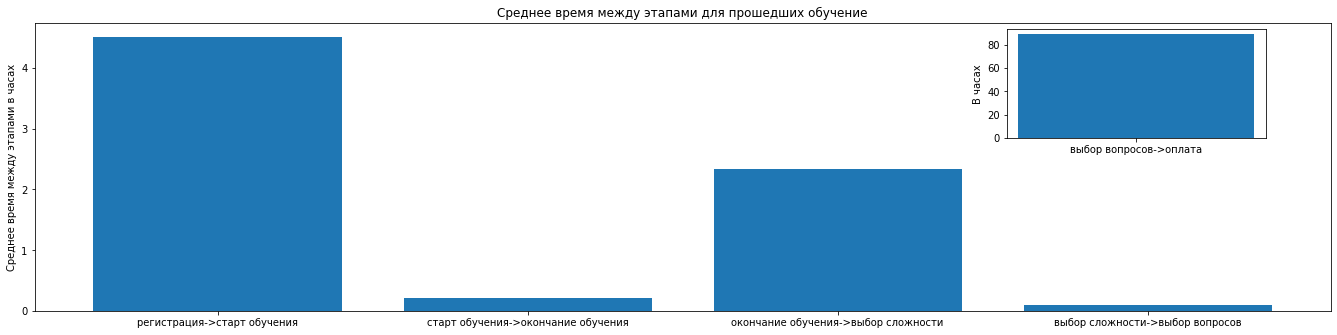

In [294]:
import matplotlib.pyplot as plt
%matplotlib inline

mean_timedelta_finished = [
    mean_timedelta_merged_df_1_finished, 
    mean_timedelta_merged_df_2_finished, 
    mean_timedelta_merged_df_3_finished, 
    mean_timedelta_merged_df_4_finished, 
    #mean_timedelta_merged_df_5_finished
]

name = [
    'регистрация->старт обучения', 
    'старт обучения->окончание обучения', 
    'окончание обучения->выбор сложности', 
    'выбор сложности->выбор вопросов', 
    #'выбор вопросов->оплата'
]

#визуализация главного графика
fig = plt.figure(figsize=(18, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = name, height = mean_timedelta_finished);
main_axes.set_ylabel('Среднее время между этапами в часах')
main_axes.set_title('Среднее время между этапами для прошедших обучение')
#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.75, 0.6, 0.2, 0.38])
insert_axes.bar(x = 'выбор вопросов->оплата', height = mean_timedelta_merged_df_5_finished, width=0.5);
insert_axes.set_ylabel('В часах')
insert_axes.xaxis.set_tick_params()

График для пользователей, не начинавших обычение:

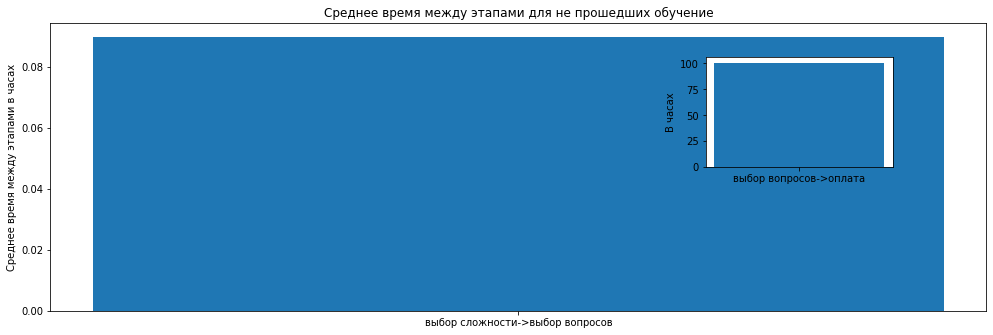

In [295]:
import matplotlib.pyplot as plt
%matplotlib inline

mean_timedelta_not_started = [
    mean_timedelta_merged_df_4_not_started, 
    #mean_timedelta_merged_df_5_not_started
]

name_2 = [
    'выбор сложности->выбор вопросов', 
    #'выбор вопросов->оплата'
]

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = name_2, height = mean_timedelta_not_started)
main_axes.set_ylabel('Среднее время между этапами в часах')
main_axes.set_title('Среднее время между этапами для не прошедших обучение')
#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.7, 0.5, 0.2, 0.38])
insert_axes.bar(x = 'выбор вопросов->оплата', height = mean_timedelta_merged_df_5_not_started, width=0.5);
insert_axes.set_ylabel('В часах')
insert_axes.xaxis.set_tick_params()

### ВЫВОД

Сравнив среднее время между прохождением этапов у пользоватлей проходивших и не проходивших обучение, можно сказать, что пользователи, прошедшие обучение осуществляют оплату дополнительного пакета вопросов в среднем на 11 часов быстрее, чем пользователи, не проходившие обучение (т.е. быстрее на 11%).






Проверим, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
Сформируем группы пользователей начавших обучение и закончивших обучение, добавим колонку с информацией об оплате по каждому пользователю, сгруппируем пользователей еще раз их количеству событий.

Для группы пользователей, начавших обучение:

In [296]:
count_users_with_started_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_start"].groupby(by='user_id')['user_id'].agg(count_start='count')
count_users_with_started_tutorial = count_users_with_started_tutorial.reset_index()
users_with_purchase = purchase_df['user_id'].unique()
count_users_with_started_tutorial['purchase_flg'] = count_users_with_started_tutorial.apply(lambda x: 1 if x['user_id'] in users_with_purchase else 0, axis=1)
tutorial_started_df = count_users_with_started_tutorial.groupby(by='count_start').agg(\
                       users=pd.NamedAgg(column='user_id', aggfunc='count'),\
                       clients=pd.NamedAgg(column='purchase_flg', aggfunc='sum'))
tutorial_started_df = tutorial_started_df.reset_index()
tutorial_started_df['percent'] = tutorial_started_df['clients'] / tutorial_started_df['users'] * 100
print(tutorial_started_df)

   count_start  users  clients    percent
0            1   9103     1207  13.259365
1            2   1589      218  13.719320
2            3    427       51  11.943794
3            4    221       30  13.574661
4            5    109       16  14.678899
5            6    116       14  12.068966
6            7     94       12  12.765957
7            8     86       13  15.116279
8            9    113       17  15.044248


Для группы пользователей, закончивших обучение:

In [297]:
count_users_with_finished_tutorial=total_events_df[total_events_df["event_type"] == "tutorial_finish"].groupby(by='user_id')['user_id'].agg(count_finish='count')
count_users_with_finished_tutorial = count_users_with_finished_tutorial.reset_index()
count_users_with_finished_tutorial['purchase_flg'] = count_users_with_finished_tutorial.apply(lambda x: 1 if x['user_id'] in users_with_purchase else 0, axis=1)
tutorial_finished_df = count_users_with_finished_tutorial.groupby(by='count_finish').agg(\
                       users=pd.NamedAgg(column='user_id', aggfunc='count'),\
                       clients=pd.NamedAgg(column='purchase_flg', aggfunc='sum'))
tutorial_finished_df = tutorial_finished_df.reset_index()
tutorial_finished_df['percent'] = tutorial_finished_df['clients'] / tutorial_finished_df['users'] * 100
print(tutorial_finished_df)

   count_finish  users  clients    percent
0             1   8015     1143  14.260761
1             2   1321      182  13.777441
2             3    345       44  12.753623
3             4    178       19  10.674157
4             5    117       19  16.239316
5             6    101       15  14.851485
6             7     97       15  15.463918
7             8     54        6  11.111111
8             9     22        4  18.181818


Составим график для групп пользователей, начавших обучение.

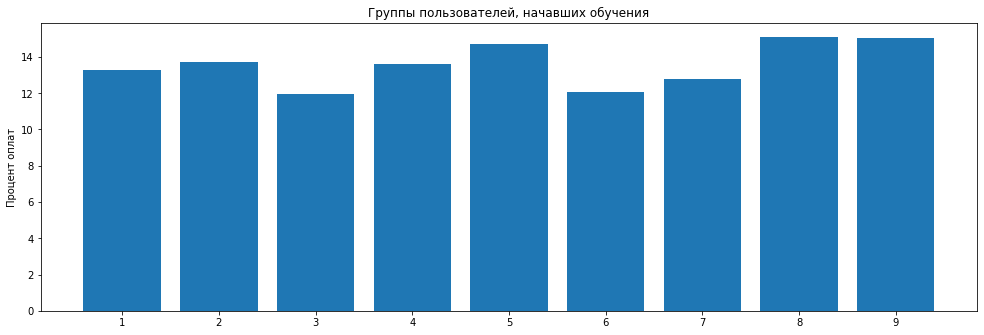

In [298]:
import matplotlib.pyplot as plt
%matplotlib inline

count = tutorial_started_df['count_start']
percent = tutorial_started_df['percent']

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = count, height = percent);
main_axes.set_ylabel('Процент оплат')
main_axes.set_title('Группы пользователей, начавших обучения')
#plt.xticks(count)
#main_axes.set_xticks(count)
main_axes.xaxis.set_major_locator(plt.MaxNLocator(10))

Составим график для групп пользователей, закончивших обучение.

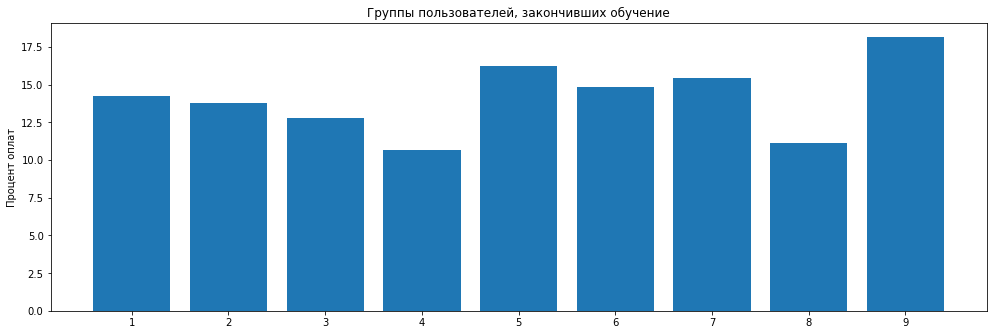

In [299]:
import matplotlib.pyplot as plt
%matplotlib inline

count = tutorial_finished_df['count_finish']
percent = tutorial_finished_df['percent']

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = count, height = percent);
main_axes.set_ylabel('Процент оплат')
main_axes.set_title('Группы пользователей, закончивших обучение')
main_axes.xaxis.set_major_locator(plt.MaxNLocator(10))

### ВЫВОД

По графику для группы пользователей, начинавших обучение, видно, что процент оплативших пользователей практически одинаков во всех подгруппах по количеству начал обучения.
По графику для группы пользователей, закончивших обучение, видно, что процент оплативших пользователей незначительно отличается в подгруппах по количеству окончаний обучения и вцелом чуть выше у тех, кто проходил обучение наибольшее количество раз.
Исходя из вышеизложенного мы можем сделать вывод, что с количеством прохождений обучений процент оплат не снижается. Сколько бы раз пользоыватели не проходил обучение - вероятность оплат остается примерно на одном уровне.

Выясним, как часто пользователи начинают обучение после выбора уровня сложности. Разделим пользователей по группам, для каждой группы найдем количество уникальных пользователей и сформируем соответсвующие датафреймы для последующего объединения (для этого произведем замену названия колонки с временем события).

In [300]:
#Пользователи, выбравшие уровень сложности
users_with_level_choice = total_events_df[total_events_df["event_type"] == "level_choice"]["user_id"].unique()
count_users_with_level_choice = len(users_with_level_choice)
users_with_level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice']
print('Проверка единичности события выбора уровня сложности:', (users_with_level_choice_df['user_id'].value_counts().mean()) == 1)
users_with_level_choice_df = users_with_level_choice_df[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})

#Пользователи, начавшие обучение
users_with_tutorial_start = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
count_users_with_tutorial_start = len(users_with_tutorial_start)
users_with_tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
users_with_tutorial_start_df = users_with_tutorial_start_df[['user_id','start_time']].rename(columns={'start_time':'start_tutorial_time'})


Проверка единичности события выбора уровня сложности: True


Объединим датасеты. Введем признак разницы во времени 'timedelta' между стартом обучения и выбором уровня сложности. Создадим дополнительный датафрейм, отфильтровав только положительные значения 'timedelta'. Определим количество количество и процент пользователей, вернувшихся к обучению после выбора уровня сложности.

In [301]:
merged_df_of_users = users_with_tutorial_start_df.merge(users_with_level_choice_df,on='user_id',how='inner')
merged_df_of_users['timedelta'] = merged_df_of_users['start_tutorial_time'] - merged_df_of_users['level_choice_time']

merged_df_of_users_2 = merged_df_of_users[merged_df_of_users['timedelta'] > pd.Timedelta(0)]
users_who_return = merged_df_of_users_2['user_id'].unique()
count_users_who_return = len(users_who_return)
print ('Количество пользователей, вернувшихся к обучению после выбора уровня сложности: ', count_users_who_return)
percent_of_users = count_users_who_return / count_users_with_level_choice
print ('Процент пользователей, вернувшихся к обучению после выбора уровня сложности (от общего количества выбравших уровень сложности): {:.2%}'.format(percent_of_users))

Количество пользователей, вернувшихся к обучению после выбора уровня сложности:  1386
Процент пользователей, вернувшихся к обучению после выбора уровня сложности (от общего количества выбравших уровень сложности): 16.61%


Диаграмма пользователей, вернувшихся к обучению после выбора уровня сложности (от общего количества выбравших уровень сложности):

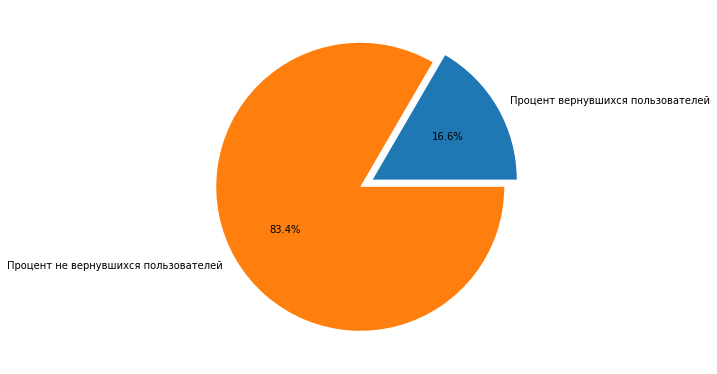

In [302]:
import matplotlib.pyplot as plt
%matplotlib inline
percent_ = [percent_of_users*100, float(100-percent_of_users*100)]
labels_=['Процент вернувшихся пользователей','Процент не вернувшихся пользователей']
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    percent_,
    labels=labels_,
    autopct='%.1f%%',
    explode = [0.1, 0]
);

### ВЫВОД

По диаграмме видно, что более 16% пользователей решили пройти обучение после выбора уровня сложности. Данный показатель требует дальнейшего наблюдения. Его увеличение будет означать, что процесс взаимодействия с игрой усложнен.